# 第7章 : VAE

## VAEとは
### デコーダ
VAEはGMMと同様に潜在変数を持つモデルで、次の2つの作業でデータを生成する
1. 潜在変数$z$を固定の正規分布から生成
2. ニューラルネットワークによって潜在変数$z$から観測変数$x$へ変換

ここで、潜在変数$\boldsymbol{z} \in \mathbb{R}^H$は固定の正規分布から生成される。つまり、
$$
p\left(z\right) = \mathcal{N}\left(\boldsymbol{z};\boldsymbol{0},\boldsymbol{I}\right)
$$
とかける。続いて、この潜在変数$z$から観測変数$x$へニューラルネットワークを用いて変換するが、ニューラルネットワークは確率分布として$p\left(x|z\right)$をモデル化する必要がある。そこで、ニューラルネットワークの出力ベクトルを平均ベクトルとするような正規分布からサンプリングされたものを観測変数とする。
$$
\begin{align}
\hat{\boldsymbol{x}} &= {\rm{NeuralNet}\left(\boldsymbol{z};\boldsymbol{\theta}\right)}\\
p_{\boldsymbol{\theta}}\left(\boldsymbol{x} | \boldsymbol{z} \right) &= \mathcal{N}\left(\boldsymbol{x};\hat{\boldsymbol{x}},\boldsymbol{I}\right)
\end{align}
$$
つまり、デコーダの処理全体は以下
1. 潜在変数$を固定の正規分布から生成
2. ニューラルネットワークによって潜在変数から出力を得る
3. 得られた出力を平均とする正規分布からサンプリングして観測変数を得る

### EMアルゴリズムの問題点
VAEはGMMと同じく潜在変数を持つモデルであるため、EMアルゴリズムを用いた学習が理論的には可能であるが、実現は難しい。

EMアルゴリズムのEステップでは、$q^{(n)}\left(z\right) = p_{\theta}\left(z | x^{(n)}\right)$という計算を行う。VAEでは、その事後分布$p_{\theta}\left(z | x^{(n)}\right)$を求めるには
$$
\begin{align}
p_{\boldsymbol{\theta}}(\boldsymbol{z} \mid \boldsymbol{x}^{(n)}) &= \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)} , \boldsymbol{z})}{p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)})} \\
&= \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)}, \boldsymbol{z})}{\int p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)} , \boldsymbol{z})d\boldsymbol{z}}
\end{align}
$$
となる。GMMでは離散値の潜在変数だっただめ実装できたが、VAEでは連続変数で積分が出てくるため実装が困難である。

### エンコーダ
ここからVAEの学習アルゴリズムを導出する。

EMアルゴリズムにおいて対数尤度の下界としてELBOを得る過程は以下であった。
$$
\begin{align}
\log p_\theta(\boldsymbol{x}) &= \int q(\boldsymbol{z}) \log \frac{p_\theta(\boldsymbol{x}, \boldsymbol{z})}{q(\boldsymbol{z})} \, d\boldsymbol{z} + D_{\mathrm{KL}}(q(\boldsymbol{z}) \| p_\theta(\boldsymbol{z} \mid \boldsymbol{x})) \\
&\geq \underbrace{\int q(\boldsymbol{z}) \log \frac{p_\theta(\boldsymbol{x}, \boldsymbol{z})}{q(\boldsymbol{z})} \, d\boldsymbol{z}}_{\text{ELBO}}
\end{align}
$$
これに対して、EMアルゴリズムでは$q(z)$の更新(Eステップ)と$\theta$の更新(Mステップ)を交互に繰り返すのであった。しかし、VAEでは上述のとおり、$q(z)$の更新の際に連続変数の積分が出てきて困難である。

そこで、VAEでは次のようにする
1. $q(z)$を簡単な確率分布(例えば、正規分布)に限定する。
2. その限定された確率分布の中でELBOの最大化を行う

(このように、計算不可能な事後分布を簡単な確率分布で近似する手法を変分近似(Variational Approximation)や変分ベイズ(Variational bayes)とよぶ。VAEのVはこれが由来)

ここで、$q(z)$を正規分布に限定する。このとき、正規分布のパラメータを$\boldsymbol{\psi} = \{\boldsymbol{\mu}, \boldsymbol{\Sigma}\}$として
$$
q_{\boldsymbol{\psi}} = \mathcal{N}\left(\boldsymbol{z};\boldsymbol{\mu},\boldsymbol{\Sigma}\right)
$$
とする。

このとき、対数尤度は
$$
\log p_\theta(\boldsymbol{x}) = \underbrace{\int q_{\boldsymbol{\psi}}(\boldsymbol{z}) \log \frac{p_\theta(\boldsymbol{x}, \boldsymbol{z})}{q_{\boldsymbol{\psi}}(\boldsymbol{z})} \, d\boldsymbol{z}}_{\text{ELBO}} + D_{\mathrm{KL}}(q_{\boldsymbol{\psi}}(\boldsymbol{z}) \| p_\theta(\boldsymbol{z} \mid \boldsymbol{x}))
$$
となる。次に、ELBOを$\boldsymbol{\theta}$と$\boldsymbol{\psi}$に関して最大化する。
このとき、$\boldsymbol{\psi}$に関してELBOを最大化すると$q_{\boldsymbol{\psi}}(\boldsymbol{z})$は$p_\theta(\boldsymbol{z} \mid \boldsymbol{x})$に最も近づく。

いま、1つのデータに対して考えているがN個のデータセットに拡張すると目的関数(ELBO)は
$$
\sum_{n=1}^{N} \text{ELBO}(\boldsymbol{x}^{(n)}; \boldsymbol{\theta}, \boldsymbol{\psi}^{(n)}) = \sum_{n=1}^{N} \int q_{\boldsymbol{\psi}^{(n)}}(\boldsymbol{z}) \log \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)}, \boldsymbol{z})}{q_{\boldsymbol{\psi}^{(n)}}(\boldsymbol{z})}d\boldsymbol{z}
$$
となる。

ここでは、各データ$\boldsymbol{x}^{(n)}$に対応した確率分布$q_{\boldsymbol{\psi}^{(n)}}$を用意する必要があるが、これをニューラルネットワークを用いて実現する。具体的には、各データ$\boldsymbol{x}^{(n)}$を入力として、その入力にふさわしい正規分布のパラメータ${\boldsymbol{\mu}^{(n)},\boldsymbol{\Sigma}^{(n)}}$を出力させる。この観測データから潜在変数へと変換するニューラルネットワークをエンコーダという。このように近似事後分布のパラメータを1つのニューラルネットワークによって計算する手法は償却推論(Amortized Inference)と呼ばれる。ここで、潜在変数$\boldsymbol{z}$を$H$次元のベクトルとすると、$\boldsymbol{\mu},\boldsymbol{\Sigma}$はそれぞれ$H$次元のベクトル、$H \times H$の行列となるが、計算コスト削減のために$\Sigma$は対角共分散行列に限定する。対角共分散行列は、非対角成分がすべて$0$の行列っである。そのため、共分散行列の出力は、$H$次元のベクトルでよい。

よって、エンコーダの処理は
$$
\begin{align}
\boldsymbol{\mu}, \boldsymbol{\sigma} &= \mathrm{NeuralNet}\left(\boldsymbol{x};\boldsymbol{\phi}\right)\\
q_{\phi\left(\boldsymbol{z} \mid \boldsymbol{x} \right)} &= \mathcal{N}\left(\boldsymbol{z};\boldsymbol{\mu},\boldsymbol{\sigma^2}\boldsymbol{I}\right)
\end{align}
$$
とかける。ここで、$\boldsymbol{\sigma^2}\boldsymbol{I}$はNNの出力ベクトル(H次元)から対角共分散行列に変換している。

エンコーダの処理を数式ではなく日本語にすると、
1. 観測データとカテゴリカル分布のパラメータを入力としてNNから平均と分散を得る
2. 得られた平均と分散の正規分布からサンプリングすることで潜在変数を得る

### ELBO
ELBOの最大化を考える。
$$
\sum_{n=1}^{N} \text{ELBO}(\boldsymbol{x}^{(n)}; \boldsymbol{\theta}, \boldsymbol{\psi}^{(n)}) = \sum_{n=1}^{N} \int q_{\boldsymbol{\psi}^{(n)}}(\boldsymbol{z}) \log \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}^{(n)}, \boldsymbol{z})}{q_{\boldsymbol{\psi}^{(n)}}(\boldsymbol{z})}d\boldsymbol{z}
$$

ここで、ELBOを以下のように変形する。
$$
\begin{align}
\text{ELBO}(\boldsymbol{x}; \boldsymbol{\theta}, \boldsymbol{\phi})\\ & = \int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})} d\boldsymbol{z} \\
& = \int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z}) p(\boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})} d\boldsymbol{z} \\
& = \int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z}) d\boldsymbol{z} + \int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log \frac{p(\boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})} d\boldsymbol{z}\\
&=\int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log p_{\boldsymbol{\theta}}(\boldsymbol{x}\mid \boldsymbol{z}) d\boldsymbol{z} - \int q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \log \frac{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}{p\left(\boldsymbol{z}\right)} d\boldsymbol{z} \\
& = \underbrace{\mathbb{E}_{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})} [\log p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z})]}_{J_1} - \underbrace{D_{KL}(q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \| p(\boldsymbol{z}))}_{J_2}
\end{align}
$$

まず、$J1$については期待値であるためモンテカルロ法によって近似できる。具体的には$q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})$からいくつか乱数を生成して、得られた乱数を使って$\log p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z})$の平均を計算する。サンプルサイズを1とすれば
$$
\begin{align}
\boldsymbol{\mu}, \boldsymbol{\sigma} &= \mathrm{NeuralNet}\left(\boldsymbol{x};\boldsymbol{\phi}\right) \quad (\text{Encoder})\\
\boldsymbol{z} &\sim \mathcal{N} \left(\boldsymbol{z};\boldsymbol{\mu}, \boldsymbol{\sigma}^2\boldsymbol{I}\right) \quad (\text{Sampling})\\
\hat{\boldsymbol{x}} &= \mathrm{NeuralNet}\left(\boldsymbol{z};\boldsymbol{\theta}\right) \quad (\text{Decoder})\\
J_1 &\approx \log \mathcal{N}\left(\boldsymbol{x};\hat{\boldsymbol{x}},\boldsymbol{I}\right) \quad (\text{MonteCarlo})\\
&= \log \left( \frac{1}{\sqrt{(2\pi)^D |\boldsymbol{I}|}} \exp \left( -\frac{1}{2} (\boldsymbol{x} - \hat{\boldsymbol{x}})^T \boldsymbol{I}^{-1} (\boldsymbol{x} - \hat{\boldsymbol{x}}) \right) \right) \\
&=  \log\frac{1}{\sqrt{\left(2\pi\right)^D}} - \frac{1}{2} (\boldsymbol{x} - \hat{\boldsymbol{x}})^T \boldsymbol{I}^{-1} (\boldsymbol{x} - \hat{\boldsymbol{x}}) \\
&= - \frac{1}{2} \|\boldsymbol{x}-\hat{\boldsymbol{x}}\|^2 + \text{const}\\
&= - \frac{1}{2} \sum_{d=1}^D (x_d - \hat{x}_d)^2 + \text{const}
\end{align}
$$
となる。

続いて、$J2$については、次の2つの正規分布についてのKLダイバージェンスであるため計算可能である。(2つの正規分布のKLダイバージェンスの計算方法についてはpaper-summaryリポジトリのDDPM参照)
$$
\begin{align}
q_{\boldsymbol{\phi}}\left(\boldsymbol{z} \mid \boldsymbol{x} \right) &= \mathcal{N}\left(\boldsymbol{z};\boldsymbol{\mu},\boldsymbol{\sigma}^2\boldsymbol{I}\right) \\
p\left(\boldsymbol{z}\right) &= \mathcal{N} \left(\boldsymbol{z};\boldsymbol{0},\boldsymbol{I}\right) \\
J_2 &= D_{\mathrm{KL}} \left(q_{\boldsymbol{\phi}}\left(z \mid x \right) \mid p\left(z\right) \right) \\
&= - \frac{1}{2} \sum_{h=1}^{H}\left(1 + \log \sigma_h^2 - \mu_h^2 - \sigma_h^2 \right)
\end{align}
$$

以上より、
$$
\mathrm{ELBO}\left(\boldsymbol{x};\boldsymbol{\theta},\boldsymbol{\phi}\right) \approx - \frac{1}{2} \sum_{d=1}^D (x_d - \hat{x}_d)^2 + \frac{1}{2} \sum_{h=1}^{H}\left(1 + \log \sigma_h^2 - \mu_h^2 - \sigma_h^2 \right) + \text{const}
$$

### 変数可換トリック
上記のEncoder, Decoderを通してELBOの最適化を行うと、サンプリングの箇所で逆伝搬ができない。それを解決するのが変数可換トリック(Reparameterization Trick)である。

変数可換トリックは、$\boldsymbol{z} \sim \mathcal{N} \left(\boldsymbol{z};\boldsymbol{\mu},\boldsymbol{\sigma}^2\boldsymbol{I}\right)$のサンプリングを次のように計算する。
$$
\begin{align}
\boldsymbol{\epsilon} &\sim \mathcal{N}\left(\boldsymbol{\epsilon};\boldsymbol{0},\boldsymbol{I}\right)\\
\boldsymbol{z} &= \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}
\end{align}
$$

ここで、$\odot$はアダマール積である。このように計算された、$\boldsymbol{z}$は$\mathcal{N}\left(\boldsymbol{z};\boldsymbol{\mu},\boldsymbol{\sigma}2\boldsymbol{I}\right)$からサンプリングされた値と同じ分布に従う。このときの計算グラフは、$\boldsymbol{z}$から$\boldsymbol{\mu},\boldsymbol{\sigma}$への逆伝搬は流れて、$\boldsymbol{\epsilon}$への逆伝搬だけが切れる。これによってVAEの学習が可能になる。

## VAE実装
### 損失関数について
NNでは損失関数として最小化する関数を設定するのが一般的である一方で、VAEではELBOの最大化をおこなう。そこで、損失関数としてELBOに$-2$をかけた以下を使う
$$
\mathrm{Loss}\left(\boldsymbol{x};\boldsymbol{\theta},\boldsymbol{\phi}\right) \approx  \sum_{d=1}^D (x_d - \hat{x}_d)^2 -\sum_{h=1}^{H}\left(1 + \log \sigma_h^2 - \mu_h^2 - \sigma_h^2 \right)
$$

### Encoder, Decoderの実装
Encoderで$\boldsymbol{\sigma}$を得る際に、NNでは`nn.Linear'で$\log\boldsymbol{\sigma}^2$を得るようにする。そのあとに、$\exp \left(\log\boldsymbol{\sigma}^2\right) = \boldsymbol{\sigma}$の計算によって$\boldsymbol{\sigma}$を得る。このようにすることで、対角共分散行列で使う$\boldsymbol{\sigma}$の各要素は正であるという制約を満たせる

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

# ハイパーパラメータの設定
input_dim = 784 # 画像データxのサイズ(MNIST画像は28*28=784)
hidden_dim = 200 # NNの中間層の次元数
latent_dim = 20 # 潜在変数zの次元数
epochs = 30
learning_rate = 3e-4
batch_size = 32

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hiddne_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat


### VAE実装
`torch.randn_like`は引数に与えたテンソルと同じ形状のテンソルを生成する。生成されるテンソルの各要素は標準正規分布(平均0, 標準偏差1)からランダムにサンプリングされる

In [3]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

### 学習実装

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3770466.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 147745.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1420317.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6123602.95it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

54.219647418212894
45.29127319539388
43.10376876627604
41.93326073608399
41.287936785888675
40.85457900390625
40.50241245320638
40.213197810872394
40.05283578491211
39.89640383911133
39.74165758666992
39.68222231241862
39.56257241414388
39.45691654459635
39.40789112955729
39.32587094930013
39.20985888264974
39.204462588500974
39.167889377848304
39.09686888834636
39.03095110880534
38.98025752766927
38.916582773844404
38.91805772094727
38.871076963297526
38.81563973490397
38.769643761189776
38.72344825846354
38.70539832356771
38.63859934082031


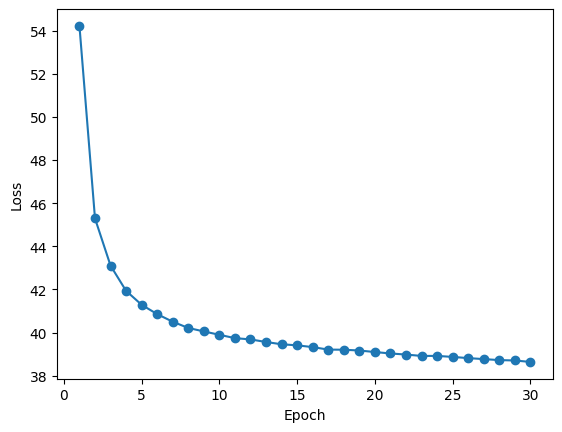

In [4]:
# データセット
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten) # 画像をフラットにする
])
dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
)

# モデルとオプティマイザ
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# 学習ループ
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0
    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(loss_avg)

# plot losses
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 新しい画像生成

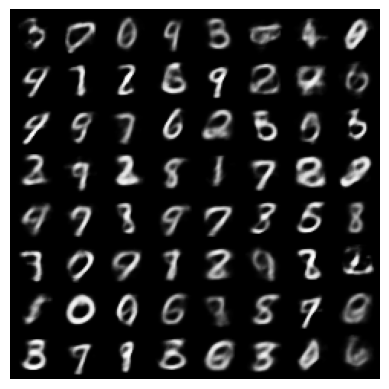

In [5]:
with torch.no_grad(): # 勾配計算を無効化(メモリの削減)
    sample_size = 64
    z = torch.randn(sample_size, latent_dim) # 潜在変数をランダムに生成
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28) # 画像の形状に変換

# グリッドで表示
grid_img = torchvision.utils.make_grid(
    generated_images,
    nrow=8,
    padding=2,
    normalize=True,
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()